# Goal: investigate code distance required to tolerate ray impact

In [43]:
import sys
sys.path.append('../')

import sinter
import matplotlib.pyplot as plt
import numpy as np
import pickle
import multiprocess as mp

from stim_surface_code.memory import MemoryPatch
from stim_surface_code.stability import StabilityPatch
from stim_lattice_surgery.lattice_surgery.single_error_metric import initialize_ops, get_processed_error_data
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model import NoiseModel, GoogleNoiseParamsNoRandomRays
from ray_delay.noise_model_patch import NoiseModelPatch
import qc_utils.matplotlib_setup as mpl_setup

In [53]:
mpl_setup.setup_default()

TODO: what about multiple rays? should we assume that you just add the added
distance again?

# Surface code memory experiment

In [31]:
generate_data = True

In [32]:
if generate_data:
    radii_mem = [0,2,4,6,8]
    d_range_mem = [7,9,11,13,15]
    strengths_mem = [0.9, 0.99, 0.999]

    tasks_Z = []
    tasks_X = []
    for strength in strengths_mem:
        for d in d_range_mem:
            for r in radii_mem:
                noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
                noise_params.cosmic_ray_params.max_strength = strength
                _patch = MemoryPatch(d, d, d)
                nmp = NoiseModelPatch(_patch, noise_params=noise_params)
                if r > 0:
                    nmp.force_cosmic_ray_by_coords((d//2, d//2), r)
                tasks_Z.append(nmp.patch.get_sinter_task({'json_metadata':{'d':d, 'r':r, 'strength':strength}}))
                tasks_X.append(nmp.patch.get_sinter_task({'json_metadata':{'d':d, 'r':r, 'strength':strength}}, observable_basis='X'))
    
    collected_results_memory_Z = sinter.collect(
        tasks=tasks_Z,
        num_workers=6,
        decoders=['pymatching'],
        max_shots=10**7,
        max_errors=1000,
    )
    print('Z done')
    collected_results_memory_X = sinter.collect(
        tasks=tasks_X,
        num_workers=6,
        decoders=['pymatching'],
        max_shots=10**7,
        max_errors=1000,
    )

    with open('data/code_expansion_distance_memory.pkl', 'wb') as f:
        pickle.dump({
            'radii': radii_mem,
            'distances': d_range_mem,
            'strengths': strengths_mem,
            'sinter_results_Z': collected_results_memory_Z,
            'sinter_results_X': collected_results_memory_X,
        }, f)
else:
    with open('data/code_expansion_distance_memory.pkl', 'rb') as f:
        data = pickle.load(f)
        radii_mem = data['radii']
        d_range_mem = data['distances']
        strengths_mem = data['strengths']
        collected_results_memory_Z = data['sinter_results_Z']
        collected_results_memory_X = data['sinter_results_X']

Z done


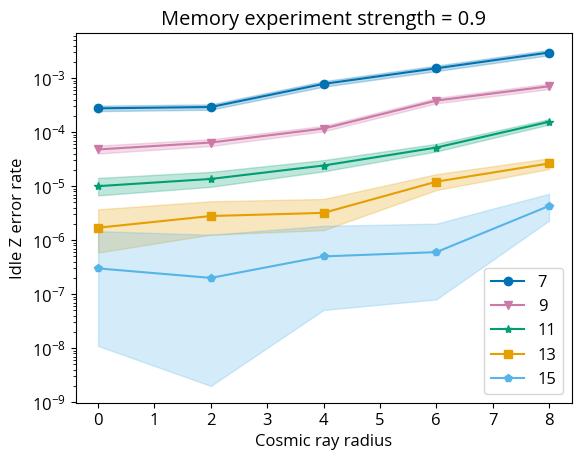

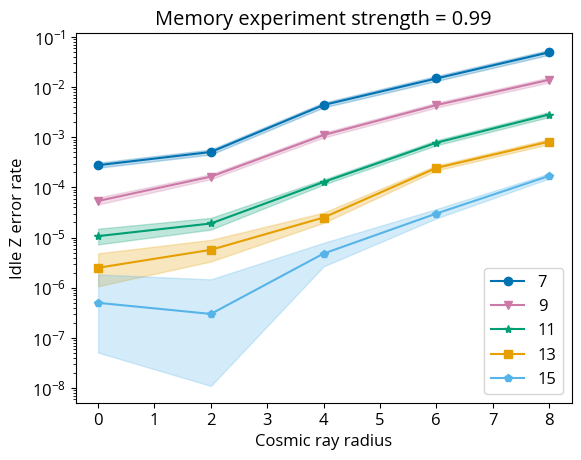

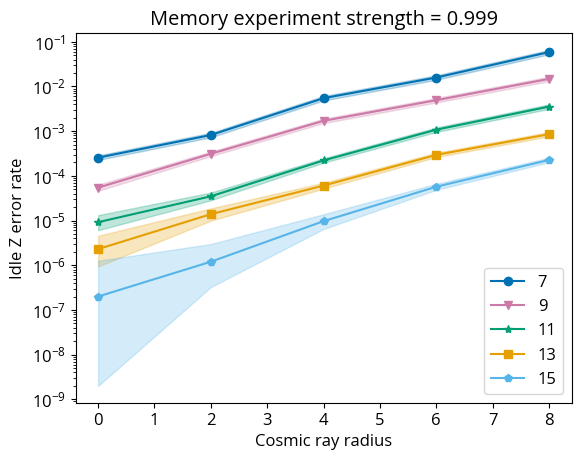

In [54]:
sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.9)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Memory experiment strength = 0.9')
plt.legend()
plt.show()

sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.99)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Memory experiment strength = 0.99')
plt.legend()
plt.show()

sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.999)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Memory experiment strength = 0.999')
plt.legend()
plt.show()

In [37]:
# for each distance, perform a linear fit to the error rate vs radius for r > 0.
# Find where this fit intersects the d=7 baseline (r = 0).
# Plot these intersections as a function of 

baseline_error_rates = np.zeros((len(strengths_mem), len(d_range_mem)))
ray_error_rates = np.zeros((len(strengths_mem), len(d_range_mem), len(radii_mem)-1))
for strength_idx in range(len(strengths_mem)):
    for d_idx,d in enumerate(d_range_mem):
        selected_results_X = [x for x in collected_results_memory_X if x.json_metadata['d'] == d and x.json_metadata['strength'] == strengths_mem[strength_idx]]
        selected_results_Z = [x for x in collected_results_memory_Z if x.json_metadata['d'] == d and x.json_metadata['strength'] == strengths_mem[strength_idx]]

        radii_X = np.array([x.json_metadata['r'] for x in selected_results_X])
        selected_error_rates_X = np.array([x.errors / x.shots for x in selected_results_X])
        # sort by radius
        radii_X, selected_error_rates_X = zip(*sorted(zip(radii_X, selected_error_rates_X)))

        radii_Z = np.array([x.json_metadata['r'] for x in selected_results_Z])
        selected_error_rates_Z = np.array([x.errors / x.shots for x in selected_results_Z])
        # sort by radius
        radii_Z, selected_error_rates_Z = zip(*sorted(zip(radii_Z, selected_error_rates_Z)))

        selected_error_rates_X = np.array(selected_error_rates_X)
        selected_error_rates_Z = np.array(selected_error_rates_Z)

        baseline_error_rates[strength_idx, d_idx] = selected_error_rates_X[0] + selected_error_rates_Z[0]/2
        ray_error_rates[strength_idx, d_idx] = selected_error_rates_X[1:] + selected_error_rates_Z[1:]/2

In [38]:
line_fits = np.zeros((len(strengths_mem), len(d_range_mem), 2))
for strength_idx in range(len(strengths_mem)):
    for d_idx,d in enumerate(d_range_mem):
        x = radii_mem[1:]
        y = ray_error_rates[strength_idx, d_idx]
        line_fit = np.polyfit(x, y, 1)
        line_fits[strength_idx, d_idx] = line_fit

intersections = np.zeros((len(strengths_mem), len(d_range_mem), len(d_range_mem)))
for strength_idx in range(len(strengths_mem)):
    for baseline_d_idx,d in enumerate(d_range_mem):
        baseline_error_rate = baseline_error_rates[strength_idx, baseline_d_idx]
        for d_idx in range(len(d_range_mem)):
            slope, intercept = line_fits[strength_idx, d_idx]
            intersections[strength_idx, baseline_d_idx, d_idx] = (baseline_error_rate - intercept) / slope

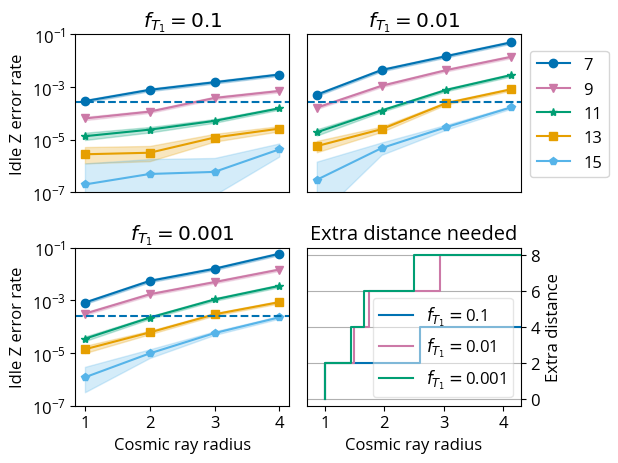

In [94]:
fig,ax = plt.subplots(2,2)



sinter.plot_error_rate(ax=ax[0,0], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.9 and x.json_metadata['r'] > 0))
ax[0,0].axhline(baseline_error_rates[0, 0], linestyle='--')
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Idle Z error rate')
ax[0,0].set_title(r'$f_{T_1} = 0.1$')
ax[0,0].set_ylim(1e-7, 1e-1)
ax[0,0].set_xticks([])

sinter.plot_error_rate(ax=ax[0,1], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.99 and x.json_metadata['r'] > 0))
ax[0,1].axhline(baseline_error_rates[1,0], linestyle='--')
ax[0,1].set_yscale('log')
ax[0,1].set_title(r'$f_{T_1} = 0.01$')
ax[0,1].set_ylim(1e-7, 1e-1)
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])
ax[0,1].legend(bbox_to_anchor=(1.45, 0.95))

sinter.plot_error_rate(ax=ax[1,0], stats=collected_results_memory_Z, x_func=lambda x: x.json_metadata['r']/2, group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: (x.json_metadata['strength'] == 0.999 and x.json_metadata['r'] > 0))
ax[1,0].axhline(baseline_error_rates[2,0], linestyle='--')
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Idle Z error rate')
ax[1,0].set_xlabel('Cosmic ray radius')
ax[1,0].set_title(r'$f_{T_1} = 0.001$')
ax[1,0].set_ylim(1e-7, 1e-1)

possible_extra_ds = np.array(d_range_mem)[1:] - d_range_mem[0]
smallest_radii = np.full((len(strengths_mem), len(possible_extra_ds)), np.inf)
for strength_idx in range(len(strengths_mem)):
    for baseline_d_idx,d in enumerate(d_range_mem):
        intersection_radii = intersections[strength_idx,baseline_d_idx,baseline_d_idx+1:]
        distances = np.array(d_range_mem[baseline_d_idx+1:])-d
        for i,(r,dist) in enumerate(zip(intersection_radii, distances)):
            if r < smallest_radii[strength_idx,i]:
                smallest_radii[strength_idx,i] = r
    
    ax[1,1].step([1] + list(smallest_radii[strength_idx]/2), [0] + list(possible_extra_ds), '-', label=r'$f_{T_1} =$'+f'{1-strengths_mem[strength_idx]:0.3g}')

    ax[1,1].set_title(f'Extra distance needed')
    ax[1,1].legend(framealpha=0.5)
    ax[1,1].set_ylabel('Extra distance')
    ax[1,1].yaxis.tick_right()
    ax[1,1].yaxis.set_label_position('right')
    ax[1,1].set_yticks([0,2,4,6,8])
    ax[1,1].grid(axis='y')
    ax[1,1].set_xlabel('Cosmic ray radius')
    ax[1,1].set_xlim(0.7,4.3)
plt.tight_layout()
plt.savefig('../figures/expansion_distance_vs_radius.pdf', bbox_inches='tight')
plt.show()

In [49]:
with open('data/code_expansion_distance_processed.pkl', 'wb') as f:
    pickle.dump({
        'possible_extra_ds': possible_extra_ds,
        'smallest_radii': smallest_radii,
        'strengths': strengths_mem,
    }, f)

In [20]:
if generate_data:
    radii_stab = [0,1,3,5,7]
    d_range_stab = [4,6,8,10,12,14,16]
    strengths_stab = [0.9, 0.99, 0.999]

    tasks = []
    for strength in strengths_stab:
        for d in d_range_stab:
            for r in radii_stab:
                noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
                noise_params.cosmic_ray_params.max_strength = strength
                _patch = StabilityPatch(d, d, d)
                nmp = NoiseModelPatch(_patch, noise_params=noise_params)
                if r > 0:
                    nmp.force_cosmic_ray_by_coords((d//2, d//2), r)
                tasks.append(nmp.patch.get_sinter_task({'json_metadata':{'d':d, 'r':r, 'strength':strength}}))
    
    collected_results_stability = sinter.collect(
        tasks=tasks,
        num_workers=6,
        decoders=['pymatching'],
        max_shots=10**7,
        max_errors=1000,
    )

    with open('data/code_expansion_distance_stability.pkl', 'wb') as f:
        pickle.dump({
            'radii': radii_stab,
            'distances': d_range_stab,
            'strengths': strengths_stab,
            'sinter_results': collected_results_stability,
        }, f)
else:
    with open('data/code_expansion_distance_stability.pkl', 'rb') as f:
        data = pickle.load(f)
        radii_stab = data['radii']
        d_range_stab = data['distances']
        strengths_stab = data['strengths']
        collected_results_stability = data['sinter_results']

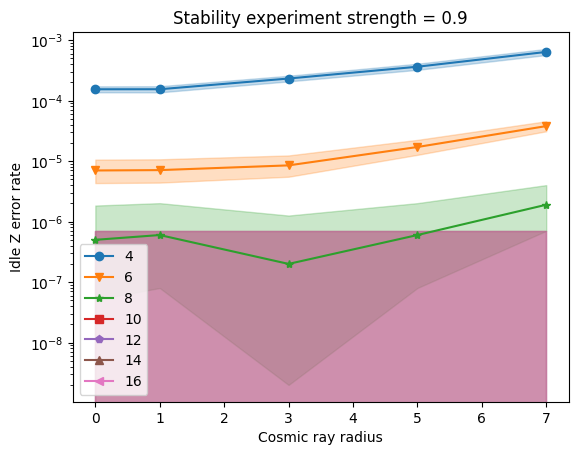

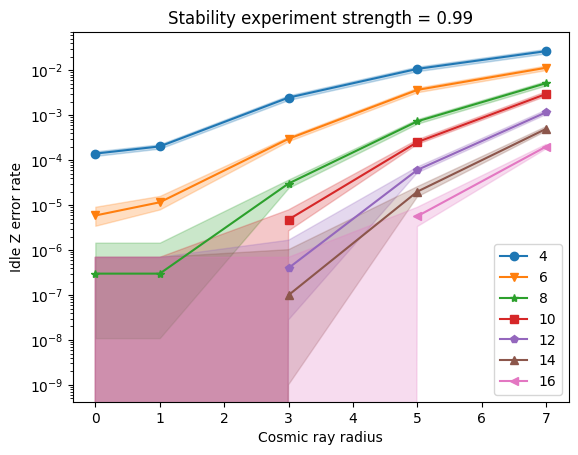

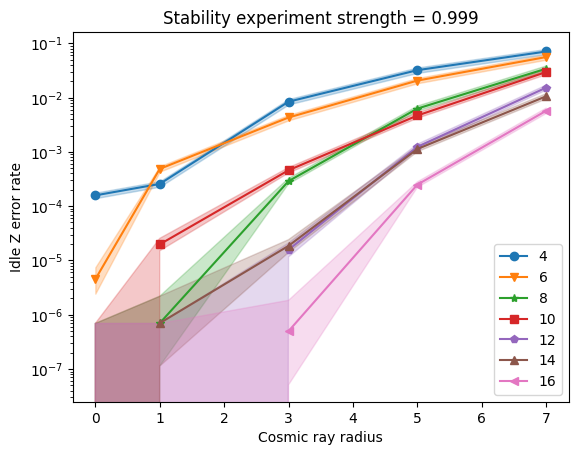

In [21]:
sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_stability, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.9)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Stability experiment strength = 0.9')
plt.legend()
plt.show()

sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_stability, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.99)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Stability experiment strength = 0.99')
plt.legend()
plt.show()

sinter.plot_error_rate(ax=plt.gca(), stats=collected_results_stability, x_func=lambda x: x.json_metadata['r'], group_func=lambda x: x.json_metadata['d'], filter_func=lambda x: x.json_metadata['strength'] == 0.999)
plt.yscale('log')
plt.ylabel('Idle Z error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Stability experiment strength = 0.999')
plt.legend()
plt.show()

Do line fit to each line, then find where each one intersects baseline (radius =
0) error rate value. This will make a new plot with radius on the x axis and
   distance on the y axis, with a point for each intersection

In [22]:
baseline_d = 7
# radii = np.arange(1,8).astype(float)
# d_range = [7,9,11,13,15,17,19]

radii = [0,1,3,5,7]
d_range = [7,9,11,13]

In [24]:
results = []
for radius in radii:
    op_list = []
    nmps = []
    for d in d_range:
        patch1 = ZXXZPatch(d, d, d, id_offset=0)
        patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
        op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])

        noise_params = GoogleNoiseParamsNoRandomRays.improve(10)
        noise_params.cosmic_ray_params.max_strength = 0.99
        nmp = NoiseModelPatch(op.patch_collection, noise_params, seed=0)
        if radius > 0:
            nmp.force_cosmic_ray_by_coords((len(op.patch_collection.device[0])//2, len(op.patch_collection.device)//2), radius)
        op_list.append(op)
        nmps.append(nmp)
    results.append(get_processed_error_data(d_range, op_list=[[data] for data in zip(op_list, nmps)]))

Running 8 circuits
Running 8 circuits
Running 8 circuits
Running 8 circuits
Running 8 circuits


In [25]:
processed_data = np.zeros((len(radii), len(d_range)))
for i,subresult in enumerate(results):
    for (d,radius_idx),result in subresult[0].items():
        print(result)
        processed_data[i+radius_idx, d_range.index(d)] = result['error_rate']

{'tl': {'obs_mistake_mask=_E_': 0.00043422947123039304, 'obs_mistake_mask=E__': 0.0002894863141535953, 'obs_mistake_mask=E_E': 8.379866988656707e-05, 'obs_mistake_mask=_EE': 2.2854182696336475e-05}, 'zl': {'obs_mistake_mask=E': 0.0013399952217224651}, 'tl_err_rate': 0.00038471207538833067, 'zl_err_rate': 0.0013399952217224651, 'error_rate': 0.0017241917847680144}
{'tl': {'obs_mistake_mask=_E_': 8.767784654099508e-05, 'obs_mistake_mask=E__': 5.579499325336051e-05, 'obs_mistake_mask=E_E': 1.7080099975518525e-05, 'obs_mistake_mask=_EE': 2.27734666340247e-06}, 'zl': {'obs_mistake_mask=E': 0.0003009170666721202}, 'tl_err_rate': 7.401376656058027e-05, 'zl_err_rate': 0.0003009170666721202, 'error_rate': 0.00037490856122712746}
{'tl': {'obs_mistake_mask=_E_': 2.0855788306796758e-05, 'obs_mistake_mask=E_E': 2.896637264832883e-06, 'obs_mistake_mask=E__': 1.2165876512298108e-05}, 'zl': {'obs_mistake_mask=E': 4.6788199013604505e-05}, 'tl_err_rate': 1.5062513777130992e-05, 'zl_err_rate': 4.67881990

In [26]:
processed_data

array([[1.72419178e-03, 3.74908561e-04, 6.18500080e-05, 9.49998394e-06],
       [1.71636541e-03, 2.92096440e-04, 7.06601064e-05, 1.21999780e-05],
       [2.11537463e-03, 3.66977576e-04, 8.85819637e-05, 1.23999745e-05],
       [3.40748577e-03, 5.30546581e-04, 1.01047395e-04, 1.67857646e-05],
       [1.02730850e-02, 1.27369337e-03, 2.11520165e-04, 2.55138412e-05]])

Text(0.5, 1.0, 'Lattice surgery experiment')

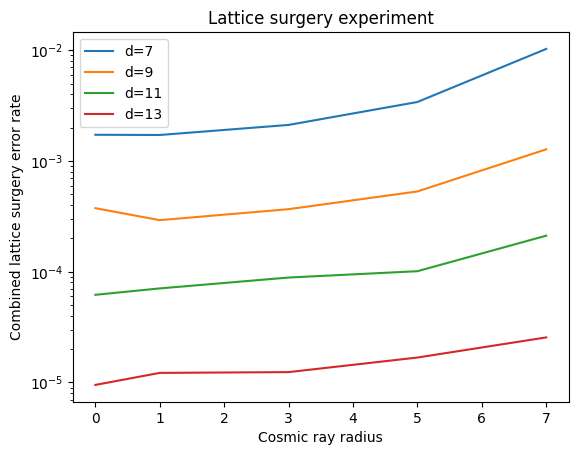

In [27]:
for col in range(processed_data.shape[1]):
    d = d_range[col]
    plt.plot(radii, processed_data[:,col], label=f'd={d}')
plt.legend()
plt.yscale('log')
plt.ylabel('Combined lattice surgery error rate')
plt.xlabel('Cosmic ray radius')
plt.title('Lattice surgery experiment')

In [30]:
results[0][0][(11,0)]['error_rate']

7.033207321327506e-05

In [17]:
results[1][0][(11,0)]['error_rate']

0.00034887576882025595

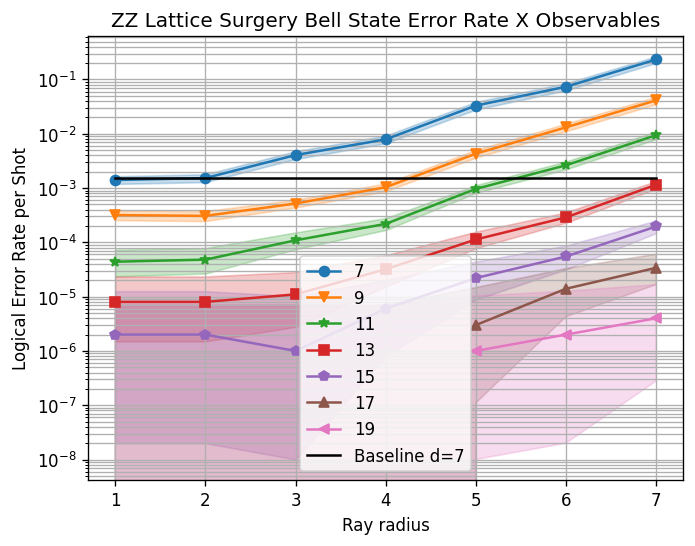

In [43]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['r'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_yscale('log')
ax.set_title(f"ZZ Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Ray radius")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')

ax.plot(radii, [result[0].errors / result[0].shots for _ in radii], label='Baseline d=7', color='black')

ax.legend()
fig.set_dpi(120)  # Show it bigger